In [ ]:
import torch
from torch import nn

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output
from itertools import product
from tqdm import trange
from pathlib import Path

data_path = Path('../data')
h5_datafile = data_path / 'movement_data.h5' 

bin_ms = 20 
lead_time_ms = 100
lead_bins = int(lead_time_ms / bin_ms)  

In [ ]:
reach_pos_and_spikes = pd.read_hdf(h5_datafile, 'reach_pos_and_spikes')

spikes_train_val, spikes_test, pos_train_val, pos_test = train_test_split(reach_pos_and_spikes['spikes'], reach_pos_and_spikes['position'], test_size=0.20, random_state=42,shuffle=True)
spikes_train, spikes_val, pos_train, pos_val           = train_test_split(spikes_train_val, pos_train_val, test_size=0.20, random_state=43,shuffle=True)

num_neurons = reach_pos_and_spikes.loc[0, 'spikes'].shape[0]
spikes_t0_bin = reach_pos_and_spikes.loc[0, 'spikes'].shape[1] - reach_pos_and_spikes.loc[0, 'position'].shape[1] 

In [ ]:
def prepare_single_trial_data(trial_spikes, trial_position, lead_bins, spikes_t0_bin, device):
    spikes_list   = []
    position_list = []
    
    for pos_bin in range(trial_position.shape[-1]):
        
        if np.all(np.isnan(trial_position[0, pos_bin:])):
            break
        
        spikes_bin = pos_bin + spikes_t0_bin
        tmp_spks = trial_spikes[:, spikes_bin - lead_bins : spikes_bin+1]
        tmp_spks = tmp_spks.T

        tmp_pos  = trial_position[:, pos_bin]

        spikes_list.append(  torch.tensor(tmp_spks, dtype=torch.float32).to(device))
        position_list.append(torch.tensor(tmp_pos , dtype=torch.float32).to(device))    

    return spikes_list, position_list

In [ ]:
def plot_pred_vs_true_pos(position_pred, position_true):
    fig, ax = plt.subplots()
    ax.plot(position_true[0] + 20, '-k', label='True Position')
    ax.plot(position_pred[0] + 20, '-.k', label='Predicted Position')
    ax.plot(position_true[1], '-b', label='True Position')
    ax.plot(position_pred[1], '-.b', label='Predicted Position')
    ax.plot(position_true[2] - 30, '-g', label='True Position')
    ax.plot(position_pred[2] - 30, '-.g', label='Predicted Position')
    plt.show()


In [106]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [122]:
class LSTM_position_decoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0):
        super(LSTM_position_decoder, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size  = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers  = num_layers,  
                            dropout     = dropout)

        # The linear layer that maps from hidden state space to 3D position
        self.hidden2pos = nn.Linear(hidden_dim, 3, device=device)

    def forward(self, spikes):
        lstm_out, _  = self.lstm(spikes)
        position_out = self.hidden2pos(lstm_out[-1])
        return position_out

In [143]:
lstm_model = LSTM_position_decoder(input_dim  = num_neurons, 
                                   hidden_dim = 32,
                                   num_layers = 1,
                                   dropout    = 0.0).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(lstm_model.parameters(), lr=0.001)

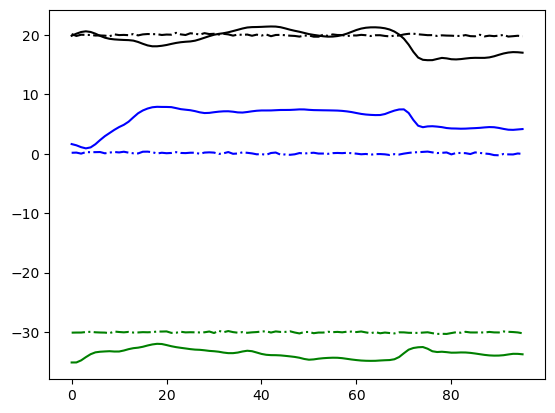

In [144]:
def predict_single_trial_position(model, spks_arr, pos_arr, lead_bins, spikes_t0_bin, device, plot=False):
    model.eval()
    with torch.inference_mode():
        spikes_list, position_list = prepare_single_trial_data(spks_arr, 
                                                               pos_arr,
                                                               lead_bins=lead_bins,
                                                               spikes_t0_bin=spikes_t0_bin,
                                                               device=device)
        
        position_pred = np.full_like(pos_arr, np.nan)
        for bin, (spks, pos) in enumerate(zip(spikes_list, position_list)):
            pos_out_tensor = model(spks)
            position_pred[:, bin] = pos_out_tensor.cpu().numpy()

        if plot:
            plot_pred_vs_true_pos(position_pred, pos_arr)

predict_single_trial_position(lstm_model, spikes_train.iloc[0], pos_train.iloc[0], lead_bins, spikes_t0_bin, device, plot=True)


In [145]:
def train_model(model, spikes_train, pos_train, spikes_val, pos_val, 
                lead_bins, spikes_t0_bin, device,loss_function, optimizer, epochs=5, print_res=True):
    
    tloss = [[] for e in range(epochs)] 
    vloss = [[] for e in range(epochs)] 
    for epoch in range(epochs): 
        #-----------------------------------------------------------------------
        # Training Step
        #-----------------------------------------------------------------------
        model.train()

        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0

        for trial, (spks_arr, pos_arr) in enumerate(zip(spikes_train.values, pos_train.values)):

            spikes_list, position_list = prepare_single_trial_data(spks_arr, 
                                                               pos_arr,
                                                               lead_bins=lead_bins,
                                                               spikes_t0_bin=spikes_t0_bin,
                                                               device=device)

            for bin, (spks, position_true) in enumerate(zip(spikes_list, position_list)):
                # print(f'epoch = {epoch}, trial = {trial}, bin = {bin}')
                
                if position_true.isnan().sum() > 0:
                     continue
                
                # if trial == 3 and bin == 1:
                #      catchhere = []

                optimizer.zero_grad()
                position_pred = model(spks)

                if position_pred.isnan().sum() > 0:
                     return

                loss = loss_function(position_pred, position_true)
                loss.backward()
                optimizer.step()

                tloss[epoch].append(loss.item())
                y_true_train.extend(list(position_true.cpu().data.numpy().flatten()))
                y_pred_train.extend(list(position_pred.cpu().data.numpy().flatten()))
                total_loss_train += loss.item()

        train_loss = total_loss_train/(spikes_train.shape[0] * len(spikes_list)) 
        train_r2 = r2_score(y_true_train, y_pred_train) 

        #-----------------------------------------------------------------------
        # Validation Step
        #-----------------------------------------------------------------------
        model.eval()
        y_true_val = list()
        y_pred_val = list()
        total_loss_val = 0

        for spks_arr, pos_arr in zip(spikes_val.values, pos_val.values):
            spikes_list, position_list = prepare_single_trial_data(spks_arr, 
                                                               pos_arr,
                                                               lead_bins=lead_bins,
                                                               spikes_t0_bin=spikes_t0_bin,
                                                               device=device)
            for bin, (spks, position_true) in enumerate(zip(spikes_list, position_list)):
                if position_true.isnan().sum() > 0:
                     continue
                position_pred = model(spks)
                loss = loss_function(position_pred, position_true)

                vloss[epoch].append(loss.item())
                y_true_val.extend(list(position_true.cpu().data.numpy().flatten()))
                y_pred_val.extend(list(position_pred.cpu().data.numpy().flatten()))
                total_loss_val += loss.item()

        val_loss = total_loss_val/(spikes_val.shape[0] * len(spikes_list)) 
        val_r2 = r2_score(y_true_val, y_pred_val) 
        if print_res:
                print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_r2: {train_r2:.4f} | val_loss: {val_loss:.4f} val_r2: {val_r2:.4f}')

    return tloss, vloss


In [146]:
train_loss, val_loss = train_model(lstm_model, 
                                   spikes_train, 
                                   pos_train, 
                                   spikes_val, 
                                   pos_val, 
                                   lead_bins, 
                                   spikes_t0_bin, 
                                   device,
                                   loss_function, 
                                   optimizer, 
                                   epochs=1000, 
                                   print_res=True)


Epoch 0: train_loss: 1.5676 train_r2: 0.8730 | val_loss: 1.4599 val_r2: 0.7967
Epoch 1: train_loss: 1.0797 train_r2: 0.9125 | val_loss: 1.4577 val_r2: 0.7970
Epoch 2: train_loss: 0.9104 train_r2: 0.9262 | val_loss: 1.3756 val_r2: 0.8084
Epoch 3: train_loss: 0.8864 train_r2: 0.9282 | val_loss: 1.4253 val_r2: 0.8015
Epoch 4: train_loss: 0.7822 train_r2: 0.9366 | val_loss: 1.4493 val_r2: 0.7981
Epoch 5: train_loss: 0.7453 train_r2: 0.9396 | val_loss: 1.3209 val_r2: 0.8160
Epoch 6: train_loss: 0.7229 train_r2: 0.9414 | val_loss: 1.2557 val_r2: 0.8251
Epoch 7: train_loss: 0.6593 train_r2: 0.9466 | val_loss: 1.1695 val_r2: 0.8371
Epoch 8: train_loss: 0.6075 train_r2: 0.9508 | val_loss: 1.1968 val_r2: 0.8333
Epoch 9: train_loss: 0.5634 train_r2: 0.9543 | val_loss: 1.2701 val_r2: 0.8231
Epoch 10: train_loss: 0.5277 train_r2: 0.9572 | val_loss: 1.2638 val_r2: 0.8240
Epoch 11: train_loss: 0.5173 train_r2: 0.9581 | val_loss: 1.2171 val_r2: 0.8305
Epoch 12: train_loss: 0.4818 train_r2: 0.9610 | va

KeyboardInterrupt: 

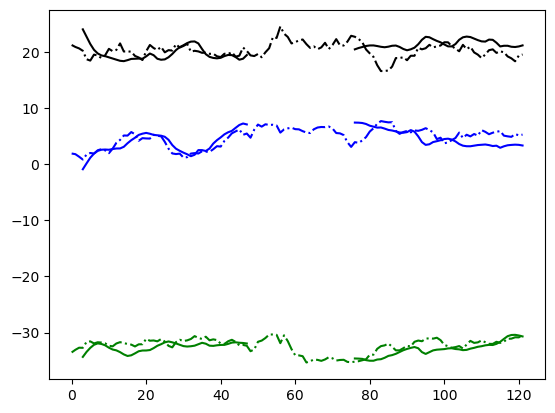

In [152]:

predict_single_trial_position(lstm_model, spikes_test.iloc[4], pos_test.iloc[4], lead_bins, spikes_t0_bin, device, plot=True)
